In [1]:
# Data Science
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Visualización
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler

torch.manual_seed(1)

dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dev

device(type='cuda', index=0)

In [2]:
datos = pd.read_csv("../Datos/trimestrales-pib.csv", index_col=[0,1])
datos

Impuestos sobre los productos, netos  Agricultura  \
Año  Trimestre                                                      
1993 T1                                     388594.0     216828.0   
     T2                                     388084.0     209611.0   
     T3                                     379390.0     179794.0   
     T4                                     422664.0     245272.0   
1994 T1                                     409250.0     212307.0   
...                                              ...          ...   
2019 T3                                     822448.0     269969.0   
     T4                                     849938.0     454425.0   
2020 T1                                     774944.0     355884.0   
     T2                                     627575.0     388108.0   
     T3                                     713290.0     305998.0   

                Cría y explotación de animales  Aprovechamiento forestal  \
Año  Trimestre                                                             
1993 T1                               111883.0                   17803.0   
     T2                               126136.0                   17044.0   
     T3                               146416.0                   16858.0   
     T4                               133375.0                   16537.0   
1994 T1                               110839.0                   16421.0   
...                                        ...                       ...   
2019 T3                               187821.0                   19273.0   
     T4                               196956.0                   20543.0   
2020 T1                               174004.0                   18816.0   
     T2                               180821.0                   15257.0   
     T3                               193131.0                   17010.0   

                Pesca, caza y captura  \
Año  Trimestre                          
1993 T1                        9059.0   
     T2                       10803.0   
     T3                        8911.0   
     T4                       10099.0   
1994 T1                        9077.0   
...                               ...   
2019 T3                       15774.0   
     T4                       17219.0   
2020 T1                       12756.0   
     T2                       14752.0   
     T3                       14996.0   

                Servicios relacionados con las actividades agropecuarias y forestales  \
Año  Trimestre                                                                          
1993 T1                                                     649.0                       
     T2                                                     498.0                       
     T3                                                     582.0                       
     T4                                                     730.0                       
1994 T1                                                     890.0                       
...                                                           ...                       
2019 T3                                                    1439.0                       
     T4                                                    4584.0                       
2020 T1                                                    1653.0                       
     T2                                                    1214.0                       
     T3                                                    1056.0                       

                Extracción de petróleo y gas  \
Año  Trimestre                                 
1993 T1                             865047.0   
     T2                             895218.0   
     T3                             901125.0   
     T4                             923834.0   
1994 T1                             895605.0   
...                                      ...   
2019 T3                             607141.0   
     

In [4]:
totales = datos.sum(axis=1)
totales

Año   Trimestre
1993  T1           10008894.0
      T2           10171035.0
      T3           10066263.0
      T4           10416101.0
1994  T1           10343396.0
                      ...    
2019  T3           18398053.0
      T4           18869807.0
2020  T1           18023219.0
      T2           15042859.0
      T3           16822015.0
Length: 111, dtype: float64

In [5]:
def dividir_series(serie_x, serie_y, test_size):
    n_obs = serie_x.shape[0]
    n = int(n_obs*(1-test_size))
    return serie_x[:n], serie_x[n:], serie_y[:n], serie_y[n:]

In [6]:
def preparar_entrada(X, y, k):
    end = X.shape[0] - k + 1
    Xl = []
    yl = []
    for i in range(end-1):
        Xt = X[i:i+k,:]
        yt = y[i+k]
        Xl.append(Xt.ravel())
        yl.append(yt)
    
    X_new = torch.Tensor(Xl).to(dev)
    y_new = torch.Tensor(yl).to(dev)
    return X_new, y_new

In [7]:
def calcular_r2(y_pred, y_true):
    ss_res = ((y_true - y_pred)**2).sum()
    y_mean = y_true.mean()
    ss_total = ((y_true - y_mean)**2).sum()
    
    return 1 - (ss_res/ss_total)

In [8]:
variables = pd.read_csv("../Datos/variables-politicas-monetaria.csv", index_col=[0,1])
variables

Base Monetaria             M1            M2  Inflacion  \
Año  Trimestre                                                           
1993 T1            3.617908e+07  2.802916e+08  6.710978e+08   1.130000   
     T2            3.579491e+07  2.904517e+08  7.016594e+08   0.513333   
     T3            3.570483e+07  3.002878e+08  7.321765e+08   0.613333   
     T4            4.085851e+07  3.098260e+08  7.626778e+08   0.440000   
1994 T1            4.308890e+07  3.190927e+08  7.931914e+08   0.746667   
...                         ...           ...           ...        ...   
2019 T3            1.562234e+09  4.351109e+09  8.981530e+09   0.253333   
     T4            1.642256e+09  4.393462e+09  9.052353e+09   0.293333   
2020 T1            1.712852e+09  4.619618e+09  9.322294e+09   0.326667   
     T2            1.833235e+09  5.047059e+09  9.983913e+09   0.343333   
     T3            1.909298e+09  5.221241e+09  1.015398e+10   0.346667   

                tasa_interes  Tipo_cambio  
Año  Trimestre                             
1993 T1             1.130000     3.107135  
     T2             0.513333     3.113394  
     T3             0.613333     3.117846  
     T4             0.440000     3.121773  
1994 T1             0.746667     3.227980  
...                      ...          ...  
2019 T3             0.253333    19.391890  
     T4             0.293333    19.192773  
2020 T1             0.326667    20.818174  
     T2             0.343333    22.582584  
     T3             0.346667    21.801972  

[111 rows x 6 columns]

## Modelado

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super().__init__()
        t_ventana, n_vars = input_dim
        self.entrada = nn.Linear(t_ventana*n_vars, hidden_units)
        self.salida = nn.Linear(hidden_units, 1)
        
    def forward(self, x):
        x = F.relu(self.entrada(x))
        x = self.salida(x)
        return x.flatten()

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(variables.values)
X.shape

(111, 6)

In [11]:
t_ventana = 10
X_prep, y_prep = preparar_entrada(X, totales.values, t_ventana)

In [12]:
X_train_t, X_test_t, y_train_t, y_test_t = dividir_series(X_prep, y_prep, 0.1)

Inicia
Termina el entrenamiento
Train RMSE tensor(94196.5391, device='cuda:0', grad_fn=<SqrtBackward>)
Test RMSE tensor(5074863., device='cuda:0', grad_fn=<SqrtBackward>)
----------
Train R^2 tensor(0.9980, device='cuda:0', grad_fn=<RsubBackward1>)
Test R^2 tensor(-20.8577, device='cuda:0', grad_fn=<RsubBackward1>)
CPU times: user 34 s, sys: 865 ms, total: 34.9 s
Wall time: 34.8 s


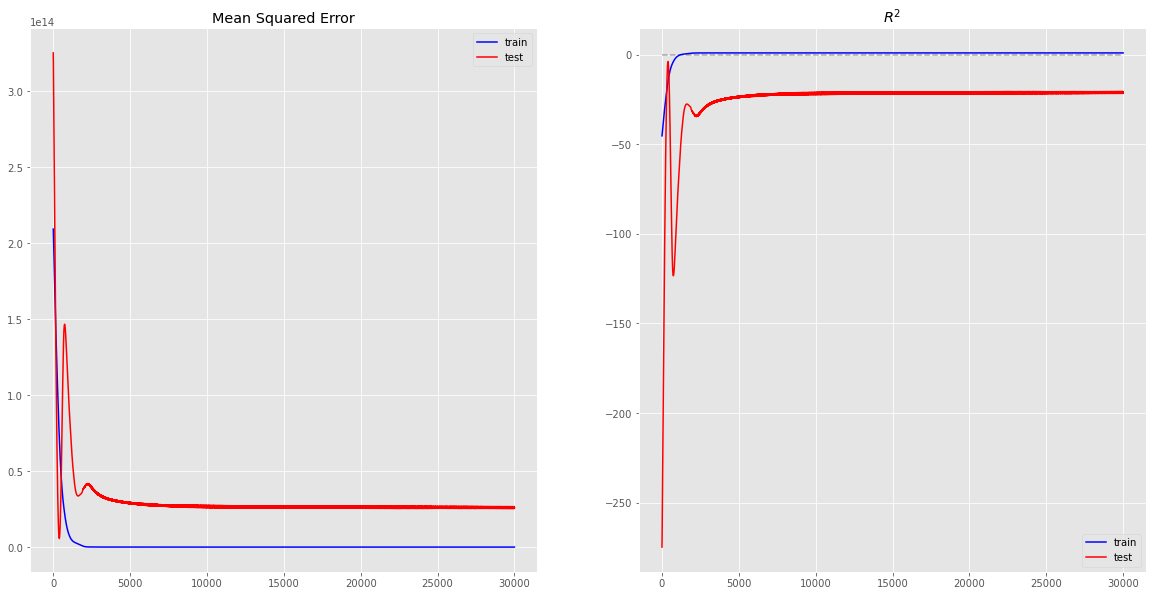

In [15]:
%%time
hidden_units = 128 # se recomiendan al menos 2n + 1
input_dim = (t_ventana, X.shape[1])

red = MLP(input_dim, hidden_units)
red.to(dev)

loss_function = nn.MSELoss()
optimizer = optim.RMSprop(red.parameters(), lr=0.1)

mse_train = []
mse_test = []

r2_train = []
r2_test = []

print("Inicia")
epochs = 30_000
r2_previous_test = float("-inf")
stop_at_best = False
for epoch in range(epochs):
    
    red.zero_grad()
    y_pred = red(X_train_t).to(dev)
    
    loss = loss_function(y_pred, y_train_t)
    mse_train.append(loss)
    r2_train.append( calcular_r2(y_pred, y_train_t ) )
    loss.backward()
    optimizer.step()
    
    # Validate
    y_pred = red(X_test_t).to(dev)
    loss = loss_function(y_pred, y_test_t)
    mse_test.append(loss)
    r2_current_test = calcular_r2(y_pred, y_test_t ) 
    r2_test.append(r2_current_test)
    
    if stop_at_best and r2_previous_test > r2_current_test:
        print("Se alcanzó el máximo en", epoch-1)
        break
    else:
        r2_previous_test = r2_current_test
    
    

print("Termina el entrenamiento")

fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].plot(mse_train, label="train", color="blue")
ax[0].plot(mse_test, label="test", color="red")
ax[0].set_title("Mean Squared Error")
ax[0].legend()

ax[1].plot(r2_train, label="train", color="blue")
ax[1].plot(r2_test, label="test", color="red")
ax[1].set_title("$R^2$")
#ax[1].set_ylim(0,1)
ax[1].hlines(0, xmin=0, xmax=epochs, ls="--", alpha=0.3, color="black")
ax[1].legend()


print("Train RMSE", mse_train[-1].sqrt())
print("Test RMSE", mse_test[-1].sqrt())
print("-"*10)
print("Train R^2", r2_train[-1])
print("Test R^2", r2_test[-1])

## Prediciendo

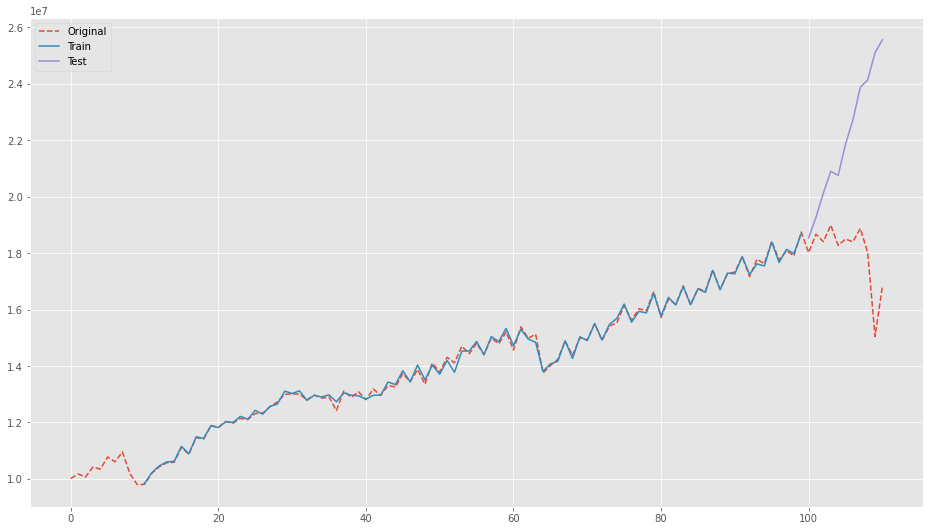

In [16]:
with torch.no_grad():
    y_pred_train = red(X_train_t).cpu().detach().numpy()
    y_pred_test = red(X_test_t).cpu().detach().numpy()

X_plot1 = np.arange(t_ventana, y_pred_train.size+t_ventana)
X_plot2 = np.arange(X_plot1.size+t_ventana, X_plot1.size + y_pred_test.size+t_ventana)
    
plt.figure(figsize=(16,9))
plt.plot(totales.values, label="Original", ls="--")
plt.plot(X_plot1, y_pred_train, label="Train")
plt.plot(X_plot2, y_pred_test, label="Test")
plt.legend()